# Introduction to TensorFlow GNN: a Graph Attention baseline for drug cardiotoxicity detection

**[July 5, 2022 UPDATE]** I've now updated this notebook to work with the latest TF-GNN release, v0.2.0; some typos were also corrected, and more resources have been added to [§5.1](#conclusions_resources).

## <a id="contents">Contents</a>

- [1. Introduction](#introduction)
    - [1.1 Graphs and Graph Neural Networks](#introduction_graphs)
    - [1.2 TensorFlow GNN](#introduction_tfgnn)
    - [1.3 Graph classification](#introduction_graph_classification)
    - [1.4 Dependencies and imports](#introduction_dependencies)
- [2. Data preparation](#dataprep)
    - [2.1 The `DatasetProvider` protocol](#dataprep_datasetprovider)
    - [2.2 Data inspection](#dataprep_inspection)
    - [2.3 `GraphTensor` batching](#dataprep_batching)
- [3. Vanilla MPNN models](#mpnn)
    - [3.1 Initial graph embedding](#mpnn_embedding)
    - [3.2 Stacking message-passing layers](#mpnn_stack)
    - [3.3 Model construction](#mpnn_construction)
- [4. Graph binary classification](#classification)
    - [4.1 Task specification](#classification_task)
    - [4.2 Training](#classification_training)
    - [4.3 Metric visualization](#classification_metrics)
- [5. Conclusions](#conclusions)
    - [5.1 Resources and acknowledgements](#conclusions_resources)

## <a id="introduction">1. Introduction</a>

### <a id="introduction_graphs">1.1 Graphs and Graph Neural Networks</a>

A [_graph_](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) consists of a collection $\mathcal{V}=\{1,\dots,n\}$ of _nodes_, sometimes also called _vertices_, and a set of _edges_ $\mathcal{E} \subseteq \mathcal{V} \times \mathcal{V}$. An edge $(i,j) \in \mathcal{E}$, also denoted $i\to j$, represents a relation from node $i$ to node $j$ which in the general case is directed (_i.e._ does not necessarily imply the converse relation $j\to i$). _Heterogeneous_ graphs can have different types of nodes and/or edges, and _decorated_ graphs may have features associated to their nodes, $h_i \in \mathbb{R}^{d_\mathcal{V}}$ for $i=1,\dots,n$, and/or their edges, $h_{i\to j} \in \mathbb{R}^{d_\mathcal{E}}$ for $(i,j)\in\mathcal{E}$.

Graphs are clearly a very general and powerful concept, which can be used to represent many different kinds of data. For example:
- A social network may be thought of as a graph where the nodes correspond to different users, and the edges correspond to their relationships (_i.e._ "friendship", "follower", etc).
- A country may be represented as a graph where cities are considered to be nodes, with roads connecting them playing the role of edges.
- ...

---

[Graph Neural Networks (GNN)](https://distill.pub/2021/gnn-intro/) are one way in which we can apply neural networks to graph-structured data in order to learn to make predictions about it. Their architecture typically involves stacking _message passing_ layers, each of which updates the features of each node $i$ in the graph by applying some function to the features of its neighbors, _i.e._ all the nodes $j$ which have edges going from $j$ to $i$. More formally, a message passing layer implements the transformation

$$h_i' = f_{\theta_\mathcal{V}}\left(h_i, \tilde{\sum}_{(j,i) \in \mathcal{E}} g_{\theta_\mathcal{E}}\left(h_j, h_{j\to i}\right)\right) \qquad\text{for}\qquad i = 1, \dots, n,$$

where $f_{\theta_\mathcal{V}}$ is a neural network applied at each node with parameters $\theta_\mathcal{V}$, and $g_{\theta_\mathcal{E}}$ is a neural network applied at each edge with parameters $\theta_\mathcal{E}$. Note that the latter may be trivial if edges do not have features. In the formula above $\tilde\sum$ in fact represents _any_ orderless aggregation function, which can be a conventional summation, an averaging operation, etc. The key point is that, being orderless, a GNN constructed in this way will be invariant under the permutation of the node labels $i=1,\dots,n$, a property which of course should hold since the labels themselves are generally speaking arbitrary: the information is encoded in the graph structure itself, not the particular labels chosen to represent it.

### <a id="introduction_tfgnn">1.2 TensorFlow GNN</a>

[TensorFlow GNN (TF-GNN)](https://github.com/tensorflow/gnn) is a fairly recent addition to the TensorFlow ecosystem, having been first released in late 2021. At this time there are relatively few resources available explaining how to use TF-GNN in practice (see [§5.1](#conclusions_resources) for more); this notebook attempts to start filling the gap by providing a basic example of the application of TF-GNN to a real-world problem, namely the classification of molecules to detect cardiotoxicity.

TF-GNN is very powerful and flexible, and can deal with large, heterogeneous graphs. We will however keep things simple here, and work instead with rather small, homogeneous graphs having few features. The main focus will be on showcasing the basic concepts and design abstractions introduced in TF-GNN to facilitate and accelerate end-to-end training of GNN models, particularly:

- [`GraphTensor` objects](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/graph_tensor.md), encapsulating graph structure and features in a TF-compatible format.
- [Pre-built GraphUpdate layers](https://github.com/tensorflow/gnn/tree/main/tensorflow_gnn/models) implementing some of the message-passing protocols most commonly used in the literature.
- The [orchestrator](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md) and related protocols, which can be used to skip most of the technical boilerplate that would otherwise be required for end-to-end training.

### <a id="introduction_graph_classification">1.3 Graph classification</a>

A prototypical example of application of GNNs are _graph classification_ problems, whereupon we are tasked to predict the _class_ of a given graph among a finite set of possible options. In the supervised setting, we have a set of labeled graphs from which we can learn the parameters $\{\theta_\mathcal{V}, \theta_{\mathcal{E}}\}$ of the GNN by minimizing a categorical crossentropy loss for our predictions. These are obtained from the GNN after applying one final aggregation or _pooling_ operation over all nodes, which again should be orderless to preserve the important property that the output is invariant under relabeling of the nodes.

In this notebook we will undertake the classification of molecules which have been labeled as being either toxic or non-toxic in the [CardioTox dataset](https://www.tensorflow.org/datasets/catalog/cardiotox) introduced by:

<a id="cardiotox">[1]</a> K. Han, B. Lakshminarayanan and J. Liu, "Reliable Graph Neural Networks for Drug Discovery Under Distributional Shift," ([arxiv:2111.12951](https://arxiv.org/abs/2111.12951))

We will take the nodes of our graphs to be the atoms in a molecule, with edges representing atomic bonds between them. Thus, our problem is a **binary classification** one (because we have just two classes) on **homogeneous graphs** (because we have only one type of nodes and one type of edges) which are both **node and edge decorated** (because, as will be seen later, the data contains features for atoms and for the bonds between them).

---

The authors of [[1]](#cardiotox) introduce various clever architectural choices to improve the performance of their model and reduce the risk of false-negative predictions, which are particularly undesirable in a toxicity-detection problem. For illustration purposes here we will not attempt to reproduce their results in full generality, but instead implement a very simple baseline based on Graph Attention Networks introduced in:

<a id="gat">[2]</a> P. Veličković, G. Cucurull, A. Casanova, A. Romero, P. Liò and Y. Bengio "Graph Attention Networks," ([arxiv:1710.10903](https://arxiv.org/abs/1710.10903))

<a id="gat2">[3]</a> S. Brody, U. Alon and E. Yahav, "How Attentive are Graph Attention Networks?," ([arxiv:2105.14491](https://arxiv.org/abs/2105.14491))

The interested reader can later try different improvements to the code in this notebook, and thanks to TF-GNN these will be easy to introduce once the training pipeline has been established.

### <a id="introduction_dependencies">1.4 Dependencies and imports</a>

Since TF-GNN is currently in an early alpha release stage, installation in the Kaggle notebook environment comes with a few hiccups. I have found that the following combination works well:

In [1]:
from IPython.display import clear_output

# install non-Python dependencies
!apt-get -y install graphviz graphviz-dev

# Upgrade to TensorFlow 2.8
!pip install tensorflow==2.8 tensorflow-io==0.25.0 tfds-nightly pygraphviz

# Install TensorFlow-GNN
!pip install tensorflow_gnn==0.2.0

# Fix some dependencies
!pip install httplib2==0.20.4

clear_output()

Now we have everything we need to proceed

In [ ]:
import pygraphviz as pgv
from tqdm import tqdm
from IPython.display import Image

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import tensorflow_gnn as tfgnn
import tensorflow_datasets as tfds

from tensorflow_gnn import runner
from tensorflow_gnn.models import gat_v2

print(f'Using TensorFlow v{tf.__version__} and TensorFlow-GNN v{tfgnn.__version__}')
print(f'GPUs available: {tf.config.list_physical_devices("GPU")}')

## <a id="dataprep">2. Data preparation</a>

Unlike other types of data, there is no standard encoding for graphs. Indeed, depending on the intended application the graph structure can be represented by:
- An adjacency matrix $A_{ij}$ specifying whether the edge $i\to j$ is present or not in $\mathcal{E}$.
- An adjacency list $N_i$ for each node $i\in\mathcal{V}$, specifying all the nodes $j\in\mathcal{V}$ for which an edge $(i, j)\in\mathcal{E}$
- A list of edges $(i,j)\in\mathcal{E}$

To address this issue TF-GNN introduces the [`GraphTensor` object](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/graph_tensor.md), which encapsulates both the graph structure and the features of the nodes, edges and the graph itself. These objects follow a [_graph schema_](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/schema.md), which specifies the types of nodes and edges as well as all the features that should be present in the graphs. The first step in any TF-GNN training pipeline should therefore be to convert the input data from whichever format is given into `GraphTensor` format. These `GraphTensor` objects can then be batched and consumed by our TF-GNN models just like a `tf.Tensor`, hugely simplifying our lives in the process.

The goal of this section is to perform the task described above, resulting in `DatasetProvider` objects for our data (see [here](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md#data-reading) and the following section for a description of the `DatasetProvider` protocol). Let us then take a look at the CardioTox dataset, which we can automatically download from TensorFlow Datasets (TF-DS):

In [ ]:
dataset_splits, dataset_info = tfds.load('cardiotox', data_dir='data/tfds', with_info=True)

clear_output()

print(dataset_info.description)

As mentioned before, we will have only one set of nodes, which we call `'atom'`, and one set of edges, which we call `'bond'`. Of course, all edges have `'atom'`-type nodes at both endpoints. Both nodes and edges have a single feature vector, the former being a 27-dimensional `'atom_features'` vector, and the latter being a 12-dimensional `'bond_features'` vector. Moreover, the graphs themselves have global features giving their _context_, in this case a toxicity class `'toxicity'`, which is in fact the label we want to predict, and a molecule id `'molecule_id'` which we will mostly ignore.

All of the above can be encoded in the following graph schema specifying the structure and contents of our graphs:

In [ ]:
graph_schema_pbtxt = """
node_sets {
  key: "atom"
  value {
    description: "An atom in the molecule."

    features {
      key: "atom_features"
      value: {
        description: "[DATA] The features of the atom."
        dtype: DT_FLOAT
        shape { dim { size: 27 } }
      }
    }
  }
}

edge_sets {
  key: "bond"
  value {
    description: "A bond between two atoms in the molecule."
    source: "atom"
    target: "atom"

    features {
      key: "bond_features"
      value: {
        description: "[DATA] The features of the bond."
        dtype: DT_FLOAT
        shape { dim { size: 12 } }
      }
    }
  }
}

context {
  features {
    key: "toxicity"
    value: {
      description: "[LABEL] The toxicity class of the molecule (0 -> non-toxic; 1 -> toxic)."
      dtype: DT_INT64
    }
  }
  
  features {
    key: "molecule_id"
    value: {
      description: "[LABEL] The id of the molecule."
      dtype: DT_STRING
    }
  }
}
"""

This schema is a textual protobuf, which we can parse to obtain a `GraphTensorSpec` (think `TensorSpec` for `GraphTensor` objects):

In [ ]:
graph_schema = tfgnn.parse_schema(graph_schema_pbtxt)
graph_spec = tfgnn.create_graph_spec_from_schema_pb(graph_schema)

We should then convert the input dataset into `GraphTensor` objects complying to `graph_spec`, which we will do with the following helper function:

In [ ]:
def make_graph_tensor(datapoint):
    """
    Convert a datapoint from the TF-DS CardioTox dataset into a `GraphTensor`.
    """
    # atom_mask is non-zero only for real atoms
    # [ V, ]
    atom_indices = tf.squeeze(tf.where(datapoint['atom_mask']), axis=1)
    
    # only keep features of real atoms
    # [ V, 27 ]
    atom_features = tf.gather(datapoint['atoms'], atom_indices)
    
    # restrict the bond mask to real atoms
    # [ V, V ]
    pair_mask = tf.gather(tf.gather(datapoint['pair_mask'], atom_indices, axis=0), atom_indices, axis=1)
    
    # restrict the bond features to real atoms
    # [ V, V, 12 ]
    pairs = tf.gather(tf.gather(datapoint['pairs'], atom_indices, axis=0), atom_indices, axis=1)
    
    # pair_mask is non-zero only for real bonds
    # [ E, 2 ]
    bond_indices = tf.where(pair_mask)
    
    # only keep features of real bonds
    # [ E, 12 ]
    bond_features = tf.gather_nd(pairs, bond_indices)
    
    # separate sources and targets for each bond
    # [ E, ]
    sources, targets = tf.unstack(tf.transpose(bond_indices))

    # active is [1, 0] for non-toxic molecules, [0, 1] for toxic molecules
    # [ ]
    toxicity = tf.argmax(datapoint['active'])
    
    # the molecule_id is included for reference
    # [ ]
    molecule_id = datapoint['molecule_id']

    # create a GraphTensor from all of the above
    atom = tfgnn.NodeSet.from_fields(features={'atom_features': atom_features},
                                     sizes=tf.shape(atom_indices))
    
    atom_adjacency = tfgnn.Adjacency.from_indices(source=('atom', tf.cast(sources, dtype=tf.int32)),
                                                  target=('atom', tf.cast(targets, dtype=tf.int32)))
    
    bond = tfgnn.EdgeSet.from_fields(features={'bond_features': bond_features},
                                     sizes=tf.shape(sources),
                                     adjacency=atom_adjacency)
    
    context = tfgnn.Context.from_fields(features={'toxicity': [toxicity], 'molecule_id': [molecule_id]})
    
    return tfgnn.GraphTensor.from_pieces(node_sets={'atom': atom}, edge_sets={'bond': bond}, context=context)

We can now map this function over the datasets to have them stream `GraphTensor` objects:

In [ ]:
train_dataset = dataset_splits['train'].map(make_graph_tensor)

In [ ]:
graph_tensor = next(iter(train_dataset))
graph_tensor

And check that the `GraphTensor` thus produced are compatible with the `GraphTensorSpec` we defined before:

In [ ]:
graph_spec.is_compatible_with(graph_tensor)

However, to avoid processing the data multiple times, which would slow down all of our input pipeline, it is convenient to first dump all the data into TFRecord files. Later on we can easily load these instead of the original TF-DS datasets over which we mapped the `make_graph_tensor` function.

**NOTE:** The `create_tfrecords` method below works nicely, is rather general and could be immediately reused for other small-scale applications. For large-scale datasets, however, alternative approaches using `tf.data.Dataset.cache` or `tf.data.Dataset.snapshot` would be preferable, as they would allow for more optimizations such as _e.g._ sharding.

In [ ]:
def create_tfrecords(dataset_splits, dataset_info):
    """
    Dump all splits of the given dataset to TFRecord files.
    """
    for split_name, dataset in dataset_splits.items():
        filename = f'data/{dataset_info.name}-{split_name}.tfrecord'
        print(f'creating {filename}...')
        
        # convert all datapoints to GraphTensor
        dataset = dataset.map(make_graph_tensor, num_parallel_calls=tf.data.AUTOTUNE)
        
        # serialize to TFRecord files
        with tf.io.TFRecordWriter(filename) as writer:
            for graph_tensor in tqdm(iter(dataset), total=dataset_info.splits[split_name].num_examples):
                example = tfgnn.write_example(graph_tensor)
                writer.write(example.SerializeToString())

In [ ]:
create_tfrecords(dataset_splits, dataset_info)

Finally, we can use the `TFRecordDatasetProvider` class to create `DatasetProvider`-compliant objects that read these TFRecord files and provide `tf.data.Dataset` objects for us to use through their `get_dataset` method:

In [ ]:
train_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-train.tfrecord')
valid_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-validation.tfrecord')
test1_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-test.tfrecord')
test2_dataset_provider = runner.TFRecordDatasetProvider(file_pattern='data/cardiotox-test2.tfrecord')

### <a id="dataprep_datasetprovider">2.1 The DatasetProvider protocol</a>

Each of the `DatasetProvider` defined above conventionally produces a dataset of serialized `GraphTensor` objects, which we need to parse before we can inspect. This is mentioned here for reference purposes only: the [orchestrator](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md#orchestration) will transparently deal with this during actual training.

To obtain the dataset we need to provide an input context:<a id="input_context"></a>

In [ ]:
train_dataset = train_dataset_provider.get_dataset(context=tf.distribute.InputContext())

We then map `tfgnn.parse_single_example` over this dataset, specifying the appropriate `GraphTensorSpec` for our graphs:

In [ ]:
train_dataset = train_dataset.map(lambda serialized: tfgnn.parse_single_example(serialized=serialized, spec=graph_spec))

And we can then stream `GraphTensor` objects as before

In [ ]:
graph_tensor = next(iter(train_dataset))
graph_tensor

### <a id="dataprep_inspection">2.2 Data inspection</a>

The node and edge features are not particularly illustrative, but we can nevertheless access them directly if necessary. First, note that this particular molecule has the following number $V = |\mathcal{V}|$ of atoms:

In [ ]:
graph_tensor.node_sets['atom'].sizes

Their features are collected in a tensor of shape `(V, 27)`, which we can access like so:

In [ ]:
graph_tensor.node_sets['atom']['atom_features']

Similarly, the number $E = |\mathcal{E}|$ of bonds in the molecule is:

In [ ]:
graph_tensor.edge_sets['bond'].sizes

Their features are collected in a tensor of shape `(E, 12)`, which we can access like so:

In [ ]:
graph_tensor.edge_sets['bond']['bond_features']

The ids of the edge endpoints are then stored in a couple of tensors of shape `(E,)`

In [ ]:
graph_tensor.edge_sets['bond'].adjacency.source

In [ ]:
graph_tensor.edge_sets['bond'].adjacency.target

Finally, global information about the graph is provided by its context

In [ ]:
graph_tensor.context['toxicity']

In [ ]:
graph_tensor.context['molecule_id']

With all of this we can write the following helper function to visualize the graphs:

In [ ]:
def draw_molecule(graph_tensor):
    """
    Plot the `GraphTensor` representation of a molecule.
    """
    (molecule_id,) = graph_tensor.context['molecule_id'].numpy()
    (toxicity,) = graph_tensor.context['toxicity'].numpy()

    sources = graph_tensor.edge_sets['bond'].adjacency.source.numpy()
    targets = graph_tensor.edge_sets['bond'].adjacency.target.numpy()

    pgvGraph = pgv.AGraph()
    pgvGraph.graph_attr['label'] = f'toxicity = {toxicity}\n\nmolecule_id = {molecule_id.decode()}'

    for edge in zip(sources, targets):
        pgvGraph.add_edge(edge)

    return Image(pgvGraph.draw(format='png', prog='dot'))

In [ ]:
draw_molecule(graph_tensor)

### <a id="dataprep_batching">2.3 GraphTensor batching</a>

`GraphTensor` datasets can be batched as usual, resulting in new datasets that produce higher-rank `GraphTensor` objects:

In [ ]:
batch_size = 64
batched_train_dataset = train_dataset.batch(batch_size)

In [ ]:
graph_tensor_batch = next(iter(batched_train_dataset))
graph_tensor_batch.rank

The resulting `GraphTensor` now contains features in the form of `tf.RaggedTensor`, since different graphs can have different numbers of nodes and edges:

In [ ]:
graph_tensor_batch.node_sets['atom']['atom_features'].shape

In [ ]:
graph_tensor_batch.edge_sets['bond']['bond_features'].shape

where the shapes now correspond to `(batch_size, V, 27)` and `(batch_size, E, 12)`.

However, all layers in TF-GNN expect scalar graphs as their inputs, so before actually using a batch of graphs we should always "merge" the different graphs in the batch into a single graph with multiple disconnected components (of which TF-GNN automatically keeps track):

In [ ]:
scalar_graph_tensor = graph_tensor_batch.merge_batch_to_components()
scalar_graph_tensor.rank

Now the atom features again have shape `(V', 27)`, where $V' = \sum_{k=1}^{\rm batch\_size} V_k$

In [ ]:
scalar_graph_tensor.node_sets['atom']['atom_features'].shape

And the bond fetures have shape $(E', 12)$ with $E' = \sum_{k=1}^{\rm batch\_size} E_k$

In [ ]:
scalar_graph_tensor.edge_sets['bond']['bond_features'].shape

We should note, however, that once more the [orchestrator](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md#orchestration) will transparently take care of batching and merging components for us, so that we needn't worry about this as long as we don't customize the training routines.

## <a id="mpnn">3. Vanilla MPNN models</a>

A [common architecture for GNNs](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/gnn_modeling.md) consists of an initial layer which preprocesses the graph features, typically producing hidden states for nodes and/or edges, which is followed by one or more layers of message-passing working as described in the [Introduction](#introduction). The goal of this section is to define a `vanilla_mpnn_model` function which can be used to create such simple GNNs from:

- an initial layer performing the pre-processing
- a layer stacking multiple message-passing layers

### <a id="mpnn_embedding">3.1 Initial graph embedding</a>

For the first of these tasks we will use a `tfgnn.keras.layers.MapFeatures` layer to create hidden state vectors for atoms and bonds from their respective features, by passing these through a dense layer. The resulting hidden states will have dimension `hidden_size`, corresponding in the notation of the [Introduction](#introduction_graphs) to $d_\mathcal{V}$ and $d_\mathcal{E}$.

The following helper function will create an initial `MapFeatures` layer for the given hyperparameters:
- `hidden_size`: the hidden dimensions $d_\mathcal{V}$ and $d_\mathcal{E}$
- `activation`: the activation for the dense layers

In [ ]:
def get_initial_map_features(hidden_size, activation='relu'):
    """
    Initial pre-processing layer for a GNN (use as a class constructor).
    """
    def node_sets_fn(node_set, node_set_name):
        if node_set_name == 'atom':
            return tf.keras.layers.Dense(units=hidden_size, activation=activation)(node_set['atom_features'])
    
    def edge_sets_fn(edge_set, edge_set_name):
        if edge_set_name == 'bond':
            return tf.keras.layers.Dense(units=hidden_size, activation=activation)(edge_set['bond_features'])
    
    return tfgnn.keras.layers.MapFeatures(node_sets_fn=node_sets_fn,
                                          edge_sets_fn=edge_sets_fn,
                                          name='graph_embedding')

We can check that the resulting layer replaces the `'atom_features'` and `'bond_features'` with hidden states of the specified dimensions

In [ ]:
graph_embedding = get_initial_map_features(hidden_size=128)

In [ ]:
embedded_graph = graph_embedding(scalar_graph_tensor)

In [ ]:
embedded_graph.node_sets['atom'].features

In [ ]:
embedded_graph.edge_sets['bond'].features

Note that both the atom and bond features are now named `'hidden_state'`; we could of course have chosen a different name, but leaving the default `tfgnn.HIDDEN_STATE` will save us from having to specify feature names in what follows.

### <a id="mpnn_stack">3.2 Stacking message-passing layers</a>

To illustrate how to build a stack of message-passing layers, we will use the pre-built [Graph Attention (GAT) [2]](#gat) layers provided in the [`models.gat_v2` module](https://github.com/tensorflow/gnn/tree/main/tensorflow_gnn/models/gat_v2). We then define a message-passing neural network (MPNN) layer successively applying these layers with hyperparameters:
- `hidden_size`: the hidden dimensions $d_\mathcal{V}$ and $d_\mathcal{E}$
- `hops`: the number of layers in the stack

In [ ]:
class MPNN(tf.keras.layers.Layer):
    """
    A basic stack of message-passing Graph Attention layers.
    """
    def __init__(self, hidden_size, hops, name='gat_mpnn', **kwargs):
        self.hidden_size = hidden_size
        self.hops = hops
        super().__init__(name=name, **kwargs)
        
        self.mp_layers = [self._mp_factory(name=f'message_passing_{i}') for i in range(hops)]
    
    def _mp_factory(self, name):
        return gat_v2.GATv2GraphUpdate(num_heads=1,
                                       per_head_channels=self.hidden_size,
                                       edge_set_name='bond',
                                       sender_edge_feature=tfgnn.HIDDEN_STATE,
                                       name=name)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'hidden_size': self.hidden_size,
            'hops': self.hops
        })
        return config
        
    def call(self, graph_tensor):
        for layer in self.mp_layers:
            graph_tensor = layer(graph_tensor)
        return graph_tensor

We can now check that this layer processes the embedded graphs that come out from the initial feature map:

In [ ]:
mpnn = MPNN(hidden_size=128, hops=8)

In [ ]:
hidden_graph = mpnn(embedded_graph)

In [ ]:
hidden_graph.node_sets['atom'].features

In [ ]:
hidden_graph.edge_sets['bond'].features

### <a id="mpnn_construction">3.3 Model construction</a>

We are now ready to combine both ingredients into a `tf.keras.Model` that takes a `GraphTensor` representing a molecule as input, and produces as its output another `GraphTensor` with hidden states for all the atoms. We use Keras' functional API to define a `vanilla_mpnn_model` helper function returning the desired `tf.keras.Model`:

In [ ]:
def vanilla_mpnn_model(graph_tensor_spec, init_states_fn, pass_messages_fn):
    """
    Chain an initialization layer and a message-passing stack to produce a `tf.keras.Model`.
    """
    graph_tensor = tf.keras.layers.Input(type_spec=graph_tensor_spec)
    embedded_graph = init_states_fn(graph_tensor)
    hidden_graph = pass_messages_fn(embedded_graph)
    return tf.keras.Model(inputs=graph_tensor, outputs=hidden_graph)

In [ ]:
model = vanilla_mpnn_model(graph_tensor_spec=graph_spec,
                           init_states_fn=graph_embedding,
                           pass_messages_fn=mpnn)
model.summary()

For later convenience, let us encapsulate all of this logic in a function we can use to get model constructors for fixed hyperparameters. The returned constructor by convention takes only the `GraphTensorSpec` of the input graphs for the model, and for good measure our constructor will also add some $L_2$ regularization through an `l2_coefficient` hyperparameter:

In [ ]:
def get_model_creation_fn(hidden_size, hops, activation='relu', l2_coefficient=1e-3):
    """
    Return a model constructor for a given set of hyperparameters.
    """
    def model_creation_fn(graph_tensor_spec):
        initial_map_features = get_initial_map_features(hidden_size=hidden_size, activation=activation)
        mpnn = MPNN(hidden_size=hidden_size, hops=hops)
        
        model = vanilla_mpnn_model(graph_tensor_spec=graph_tensor_spec,
                                   init_states_fn=initial_map_features,
                                   pass_messages_fn=mpnn)
        model.add_loss(lambda: tf.reduce_sum([tf.keras.regularizers.l2(l2=l2_coefficient)(weight) for weight in model.trainable_weights]))
        return model
    return model_creation_fn

In [ ]:
mpnn_creation_fn = get_model_creation_fn(hidden_size=128, hops=8)

In [ ]:
model = mpnn_creation_fn(graph_spec)
model.summary()

## <a id="classification">4. Graph binary classification</a>

### <a id="classification_task">4.1 Task specification</a>

Having a GNN model at our disposal, we are now ready to apply it to the task at hand, namely the binary classification of molecules predicting their toxicity. This involves:

1. Adding a readout and prediction head, which computes logits for each class from the features computed by the GNN.
1. Defining the loss function to be minimized, which in this case should be a categorical crossentropy loss.
1. Defining the metrics we are interested in measuring during training and validation.

The [orchestrator](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md) defines the `Task` protocol to achieve these goals, and conveniently provides a pre-implemented `GraphBinaryClassification` class which complies with this protocol. While we could use it as is, for illustration purposes here we will extend its basic implementation in two ways:
- We will include the AUROC metric, which is reported by the authors of [[1]](#cardiotox) (other metrics reported there can be added in a similar fashion).
- We will generalize the readout and prediction head to include a hidden layer.

First, we define a simple wrapper around the `tf.keras.metrics.AUC` class to adapt it to our conventions:

In [ ]:
class AUROC(tf.keras.metrics.AUC):
    """
    AUROC metric computation for binary classification from logits.
    
    y_true: true labels, with shape (batch_size,)
    y_pred: predicted logits, with shape (batch_size, 2)
    """
    def update_state(self, y_true, y_pred, sample_weight=None):
        super().update_state(y_true, tf.math.softmax(y_pred, axis=-1)[:,1])

Next, we subclass the `GraphBinaryClassification` task and override its `adapt` and `metrics` methods:

In [ ]:
class GraphBinaryClassification(runner.GraphBinaryClassification):
    """
    A GraphBinaryClassification task with a hidden layer in the prediction head, and additional metrics.
    """
    def __init__(self, hidden_dim, *args, **kwargs):
        self._hidden_dim = hidden_dim
        super().__init__(*args, **kwargs)
        
    def adapt(self, model):
        hidden_state = tfgnn.pool_nodes_to_context(model.output,
                                                   node_set_name=self._node_set_name,
                                                   reduce_type=self._reduce_type,
                                                   feature_name=self._state_name)
        
        hidden_state = tf.keras.layers.Dense(units=self._hidden_dim, activation='relu', name='hidden_layer')(hidden_state)
        
        logits = tf.keras.layers.Dense(units=self._units, name='logits')(hidden_state)
        
        return tf.keras.Model(inputs=model.inputs, outputs=logits)
    
    def metrics(self):
        return (*super().metrics(), AUROC(name='AUROC'))

To create an instance of this class we need to specify the node set which will be used to aggregate hidden states for prediction (remember in our case there is only one, `'atom'`) and the number of classes (two, for toxic and non-toxic), as well as the new hyperparameter `hidden_dim`:

In [ ]:
task = GraphBinaryClassification(hidden_dim=256, node_set_name='atom', num_classes=2)

This instance then provides everything we will need for training, namely:
- The loss function

In [ ]:
task.losses()

- The metrics

In [ ]:
task.metrics()

- An `adapt` method to place the readout and prediction head on top of the GNN

In [ ]:
classification_model = task.adapt(model)
classification_model.summary()

The resulting model then produces logits for each class, given a `GraphTensor` as its input:

In [ ]:
classification_model(graph_tensor)

- A `preprocessors` method, which could be used to pre-process the graphs before reaching the GNN but will remain unused here

In [ ]:
task.preprocessors()

### <a id="classification_training">4.2 Training</a>

We are now ready to train the model. First, we create a `KerasTrainer` instance which implements the [orchestrator's `Trainer` protocol](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md#training) making use of Keras' `fit` method:<a id="strategy"></a>

In [ ]:
trainer = runner.KerasTrainer(strategy=tf.distribute.get_strategy(), model_dir='model')

Next, we define a simple function conforming to [the `GraphTensorProcessorFn` protocol](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/runner.md#graphtensor-processing), which extracts the labels from the `GraphTensor` objects, for use during supervised training (this function will be mapped over the datasets that are then passed on to the `tf.keras.Model.fit` method):

In [ ]:
def extract_labels(graph_tensor):
    """
    Extract the toxicity class label from the `GraphTensor` representation of a molecule.
    Return a pair compatible with the `tf.keras.Model.fit` method.
    """
    return graph_tensor, graph_tensor.context['toxicity']

Lastly, we can put everything together and get a coffee while watching some progress bars move :-)<a id="orchestrator"></a>

In [ ]:
runner.run(
    train_ds_provider=train_dataset_provider,
    valid_ds_provider=valid_dataset_provider,
    feature_processors=[extract_labels],
    model_fn=get_model_creation_fn(hidden_size=128, hops=8),
    task=task,
    trainer=trainer,
    epochs=50,
    optimizer_fn=tf.keras.optimizers.Adam,
    gtspec=graph_spec,
    global_batch_size=128
)

### <a id="classification_metrics">4.3 Metric visualization</a>

A straightforward way to visualize the various metrics collected during training and validation is to use TensorBoard. Ideally, the following magic should work:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir model --bind_all

Unfortunately, [the TensorBoard extension has been disabled in Kaggle notebooks](https://www.kaggle.com/product-feedback/89671) and we would therefore require a workaround, possibly using a service such as [Weights and Biases](https://wandb.ai/site). This is however beyond the scope of this notebook, so I have instead uploaded the logs of a local run to [TensorBoard.dev](https://tensorboard.dev/experiment/Y85x93T8Rl6p5QqyajLFeQ/#scalars). There you should see that the loss decreases until we start to overfit (orange line is training, blue line is validation):

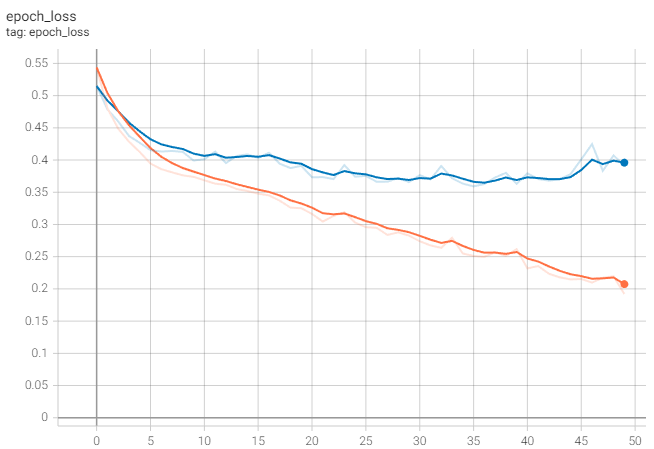

The accuracy reaches approximately 87%

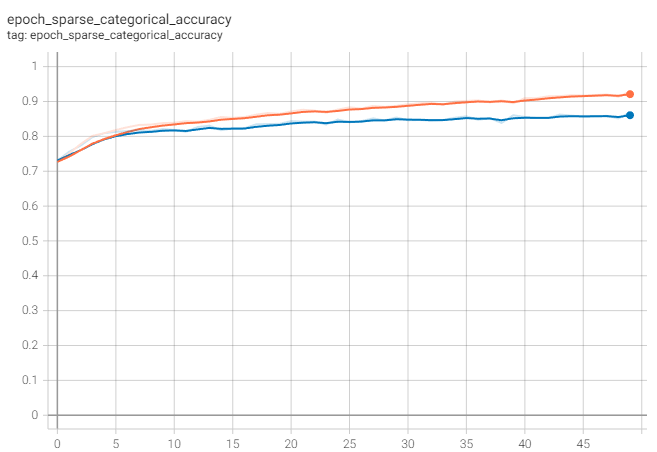

And the AUROC increases up to approximately 0.9

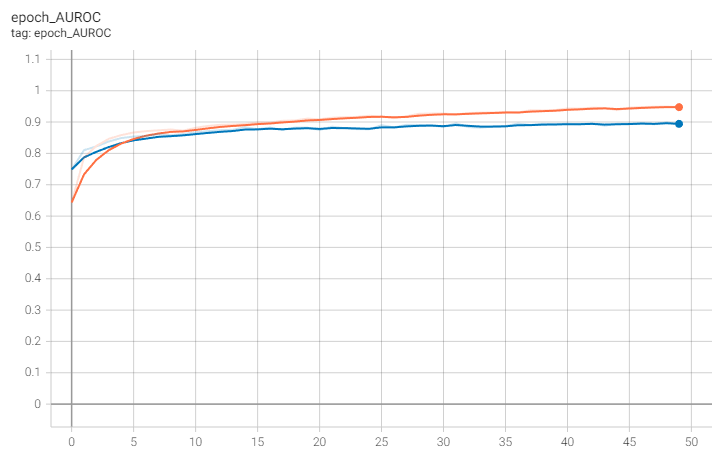

## <a id="conclusions">Conclusions</a>

In this notebook we have seen how to train a GNN model for graph binary classification using TF-GNN in an end-to-end fashion. The final [cell running the orchestrator](#orchestrator) brings together all the elements we introduced along the way, namely:

- The `DatasetProvider`-compliant objects `train_dataset_provider` and `valid_dataset_provider` constructed in [§2](#dataprep) to provide the data
- The model constructor function `get_model_creation_fn` built in [§3.3](#mpnn_construction) with the components of [§3.1](#mpnn_embedding) and [§3.2](#mpnn_stack) to assemble the GNN
- The `GraphBinaryClassification` task defined in [§4.1](#classification_task) to specify the readout and prediction head, as well as the loss and metrics.
- The `KerasTrainer` and target feature extractor created in [§4.2](#classification_training) for supervised training

While it may not be immediately obvious from such a small example, TF-GNN helped at each step by providing not just the underlying operations we need to perform on graphs, but also many useful protocols and helper functions taking care of much of the boilerplate code we would have otherwise required. Using these in tandem with the orchestrator means that all of the components are easily extendable and/or replaceable. Moreover, it allows us at least in principle to easily scale the various moving parts independently and without unnecessary pain. For example, introducing a non-trivial strategy in the [trainer](#strategy) we could distribute our training across multiple GPUs or, eventually, TPUs, while also parallelizing our input pipeline through the `InputContext` that is [passed on to the `DatasetProvider`](#input_context).

---

The results we obtained for the drug cardiotoxicity dataset are good, but not impressive. This was to be expected given the very simple GAT-based model that we implemented and the fact that we did no hyperparameter optimization or principled architectural choices. For comparison, we partially quote here [Table 1 from [1]](#cardiotox), where we see that our AUROC results are essentially consistent with the GNN baseline considered there:

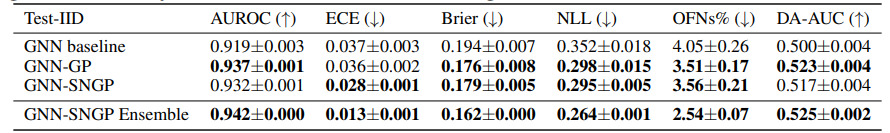

The reader is encouraged to try various modifications of the GNN architecture to improve the performance of the model, as well as study its behavior on the out-of-distribution test sets `test1_dataset_provider` and `test2_dataset_provider` that we prepared in [§2](#dataprep) but did not use here.

### <a id="conclusions_resources">5.1 Resources and acknowledgements</a>

There are a number of resources that have inspired or been used in this notebook, some of which are cited along the way. They are also collected here for reference purposes:

- The paper [[1]](#cardiotox) introducing the CardioTox dataset digs deeper in the data we have used, and builds better classification models for it

- The papers [[2]](#gat) and [[3]](#gat) introduced and popularized Graph Attention Networks

- [A Gentle Introduction to Graph Neural Networks](https://distill.pub/2021/gnn-intro/) is a good reference to start learning more about GNNs and their applications

- For those looking to dig deeper into GNNs, the [Graph Representation Learning Book](https://www.cs.mcgill.ca/~wlh/grl_book/) by W. L. Hamilton is fairly up-to-date and more comprehensive

- The [TensorFlow GNN guide](https://github.com/tensorflow/gnn/blob/main/tensorflow_gnn/docs/guide/intro.md) is a good place to start learning how to use TF-GNN, and some of this notebook's code was inspired by the examples provided there

- **[July 5, 2022 UPDATE]** Some official notebooks with TF-GNN examples are now available, see _e.g._ [Molecular Graph Classification](https://colab.research.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/intro_mutag_example.ipynb), [Solving OGBN-MAG end-to-end](https://colab.research.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/ogbn_mag_e2e.ipynb#scrollTo=udvGTpefWRE_) and [Learning shortest paths with GraphNetworks](https://colab.research.google.com/github/tensorflow/gnn/blob/master/examples/notebooks/graph_network_shortest_path.ipynb)